In [1]:
# ================================
# COMPLETE PROJECT SETUP
# ================================

# Install all required packages
!pip install albumentations==1.3.1
!pip install mlflow==2.8.1
!pip install torchinfo
!pip install efficientnet-pytorch
!pip install timm  # For Vision Transformers
!pip install seaborn
!pip install plotly
!pip install gradio  # For demo interface

# Core imports
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from PIL import Image
import cv2
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# PyTorch ecosystem
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms, models
import timm
from torchinfo import summary

# Albumentations for advanced augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# MLflow for experiment tracking
import mlflow
import mlflow.pytorch
from mlflow.tracking import MlflowClient

# Evaluation and metrics
from sklearn.metrics import (
    classification_report, confusion_matrix,
    precision_recall_fscore_support, accuracy_score
)
from sklearn.model_selection import StratifiedKFold

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")


  Using cached efficientnet_pytorch-0.7.1.tar.gz (21 kB)
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjit

Advanced Data Pipeline with Albumentations

In [2]:
# ================================
# ADVANCED DATA PIPELINE
# ================================

class AdvancedGTSRBDataset(Dataset):
    """Production-ready GTSRB dataset with comprehensive data quality checks"""

    def __init__(self, root_dir, transform=None, phase='train', quality_check=True):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.phase = phase
        self.samples = []
        self.class_names = {}
        self.quality_metrics = {}

        # Load data with quality assessment
        self._load_data()
        if quality_check:
            self._assess_data_quality()

    def _load_data(self):
        """Load data with comprehensive error handling"""
        print(f"Loading {self.phase} data from {self.root_dir}")

        for class_folder in sorted(self.root_dir.iterdir()):
            if not class_folder.is_dir():
                continue

            class_id = int(class_folder.name)
            self.class_names[class_id] = class_folder.name

            # Find CSV annotation file
            csv_files = list(class_folder.glob("*.csv"))
            if not csv_files:
                print(f"Warning: No CSV file found in {class_folder}")
                continue

            csv_path = csv_files[0]
            try:
                annotations = pd.read_csv(csv_path, sep=';')

                for _, row in annotations.iterrows():
                    img_path = class_folder / row['Filename']
                    if img_path.exists():
                        self.samples.append({
                            'path': str(img_path),
                            'label': class_id,
                            'width': row.get('Width', 0),
                            'height': row.get('Height', 0)
                        })

            except Exception as e:
                print(f"Error processing {csv_path}: {e}")

        print(f"Loaded {len(self.samples)} samples across {len(self.class_names)} classes")

    def _assess_data_quality(self):
        """Comprehensive data quality assessment"""
        print("Assessing data quality...")

        quality_issues = {
            'corrupted': [],
            'wrong_format': [],
            'too_small': [],
            'too_large': [],
            'low_quality': []
        }

        for i, sample in enumerate(self.samples):
            try:
                img = Image.open(sample['path'])

                # Check format
                if img.mode not in ['RGB', 'L']:
                    quality_issues['wrong_format'].append(i)

                # Check size
                w, h = img.size
                if w < 20 or h < 20:
                    quality_issues['too_small'].append(i)
                elif w > 1000 or h > 1000:
                    quality_issues['too_large'].append(i)

                # Convert to array for quality checks
                img_array = np.array(img.convert('RGB'))

                # Check for low quality (very dark or very bright)
                mean_brightness = np.mean(img_array)
                if mean_brightness < 30 or mean_brightness > 225:
                    quality_issues['low_quality'].append(i)

            except Exception as e:
                quality_issues['corrupted'].append(i)

        self.quality_metrics = {
            'total_samples': len(self.samples),
            'quality_issues': quality_issues,
            'issue_percentages': {
                issue: len(indices) / len(self.samples) * 100
                for issue, indices in quality_issues.items()
            }
        }

        # Print quality report
        print("\n=== DATA QUALITY REPORT ===")
        for issue, percentage in self.quality_metrics['issue_percentages'].items():
            if percentage > 0:
                print(f"{issue.replace('_', ' ').title()}: {percentage:.2f}%")

    def get_class_distribution(self):
        """Analyze class distribution for imbalance detection"""
        labels = [sample['label'] for sample in self.samples]
        distribution = pd.Series(labels).value_counts().sort_index()

        # Calculate imbalance metrics
        max_samples = distribution.max()
        min_samples = distribution.min()
        imbalance_ratio = max_samples / min_samples

        return {
            'distribution': distribution,
            'imbalance_ratio': imbalance_ratio,
            'total_classes': len(distribution),
            'samples_per_class': distribution.to_dict()
        }

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Load and convert image
        image = Image.open(sample['path']).convert('RGB')
        label = sample['label']

        # Apply transforms
        if self.transform:
            # Convert PIL to numpy for Albumentations
            image = np.array(image)
            transformed = self.transform(image=image)
            image = transformed['image']

        return image, label

# ================================
# PRODUCTION-GRADE AUGMENTATION PIPELINE
# ================================

def get_training_transforms(image_size=224):
    """Advanced augmentation pipeline for traffic signs"""
    return A.Compose([
        # Resize first
        A.Resize(image_size, image_size),

        # Geometric transformations (careful with traffic signs)
        A.Rotate(limit=15, p=0.5),  # Limited rotation for traffic signs
        A.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.1,
            rotate_limit=10,
            p=0.5
        ),
        A.Perspective(scale=(0.05, 0.1), p=0.3),  # Perspective changes

        # Weather and lighting simulation
        A.OneOf([
            A.RandomBrightnessContrast(
                brightness_limit=0.3,
                contrast_limit=0.3,
                p=1.0
            ),
            A.RandomGamma(gamma_limit=(70, 130), p=1.0),
            A.CLAHE(clip_limit=2.0, p=1.0),
        ], p=0.7),

        # Weather conditions
        A.OneOf([
            A.RandomRain(
                slant_lower=-10,
                slant_upper=10,
                drop_length=20,
                drop_width=1,
                p=1.0
            ),
            A.RandomFog(
                fog_coef_lower=0.1,
                fog_coef_upper=0.3,
                p=1.0
            ),
            A.RandomSunFlare(
                flare_roi=(0, 0, 1, 0.5),
                angle_lower=0,
                p=1.0
            ),
        ], p=0.3),

        # Noise and blur (real-world conditions)
        A.OneOf([
            A.GaussNoise(var_limit=(10.0, 50.0), p=1.0),
            A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=1.0),
        ], p=0.4),

        A.OneOf([
            A.MotionBlur(blur_limit=5, p=1.0),
            A.GaussianBlur(blur_limit=3, p=1.0),
            A.Defocus(radius=(1, 3), alias_blur=(0.1, 0.5), p=1.0),
        ], p=0.3),

        # Color space variations
        A.HueSaturationValue(
            hue_shift_limit=20,
            sat_shift_limit=30,
            val_shift_limit=20,
            p=0.4
        ),

        # Occlusion simulation (partial sign blocking)
        A.CoarseDropout(
            max_holes=3,
            max_height=32,
            max_width=32,
            min_holes=1,
            min_height=8,
            min_width=8,
            p=0.3
        ),

        # Normalization (ImageNet stats for transfer learning)
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])

def get_validation_transforms(image_size=224):
    """Clean validation transforms"""
    return A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])

# ================================
# MLFLOW EXPERIMENT SETUP
# ================================

# Initialize MLflow
mlflow.set_experiment("traffic-sign-recognition-production")

print("🚀 Foundation setup complete! Ready for data loading and analysis.")


2025/05/30 01:31:55 INFO mlflow.tracking.fluent: Experiment with name 'traffic-sign-recognition-production' does not exist. Creating a new experiment.


🚀 Foundation setup complete! Ready for data loading and analysis.


In [3]:
# Download and extract dataset
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -q GTSRB_Final_Training_Images.zip

# Load dataset with quality assessment
dataset_path = "/content/GTSRB/Final_Training/Images"
train_transforms = get_training_transforms()
val_transforms = get_validation_transforms()

# Create dataset with quality checks
full_dataset = AdvancedGTSRBDataset(
    root_dir=dataset_path,
    transform=None,  # We'll add transforms later
    quality_check=True
)

# Analyze class distribution
class_dist = full_dataset.get_class_distribution()
print(f"\nClass imbalance ratio: {class_dist['imbalance_ratio']:.2f}")


--2025-05-30 01:31:55--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  22.6MB/s    in 13s     

2025-05-30 01:32:09 (20.2 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]

Loading train data from /content/GTSRB/Final_Training/Images
Loaded 39209 samples across 43 classes
Assessing data quality...

=== DATA QUALITY REPORT ===
Low Quality: 13.77%

Class imbalance ratio: 10.71


Deep Data Analysis

In [4]:
# ================================
# COMPREHENSIVE DATA ANALYSIS PIPELINE
# ================================

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

class DataAnalyzer:
    """Production-grade data analysis for traffic sign dataset"""

    def __init__(self, dataset):
        self.dataset = dataset
        self.class_dist = dataset.get_class_distribution()

    def analyze_class_imbalance(self):
        """Deep dive into class imbalance with industry-standard metrics"""

        distribution = self.class_dist['distribution']

        # Calculate advanced imbalance metrics
        total_samples = distribution.sum()
        class_weights = total_samples / (len(distribution) * distribution)

        # Identify minority and majority classes
        minority_threshold = distribution.quantile(0.25)
        majority_threshold = distribution.quantile(0.75)

        minority_classes = distribution[distribution <= minority_threshold].index.tolist()
        majority_classes = distribution[distribution >= majority_threshold].index.tolist()

        # Create comprehensive visualization
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=('Class Distribution', 'Class Weights',
                          'Imbalance Severity', 'Cumulative Distribution'),
            specs=[[{"secondary_y": False}, {"secondary_y": False}],
                   [{"secondary_y": False}, {"secondary_y": False}]]
        )

        # Plot 1: Class distribution
        fig.add_trace(
            go.Bar(x=distribution.index, y=distribution.values,
                   name='Sample Count', marker_color='skyblue'),
            row=1, col=1
        )

        # Plot 2: Class weights (for weighted loss)
        fig.add_trace(
            go.Bar(x=class_weights.index, y=class_weights.values,
                   name='Class Weights', marker_color='orange'),
            row=1, col=2
        )

        # Plot 3: Imbalance severity
        imbalance_ratios = distribution.max() / distribution
        fig.add_trace(
            go.Bar(x=imbalance_ratios.index, y=imbalance_ratios.values,
                   name='Imbalance Ratio', marker_color='red'),
            row=2, col=1
        )

        # Plot 4: Cumulative distribution
        sorted_dist = distribution.sort_values(ascending=False)
        cumulative_pct = (sorted_dist.cumsum() / sorted_dist.sum() * 100)
        fig.add_trace(
            go.Scatter(x=list(range(len(cumulative_pct))), y=cumulative_pct.values,
                      mode='lines+markers', name='Cumulative %'),
            row=2, col=2
        )

        fig.update_layout(height=800, title_text="Class Imbalance Analysis")
        fig.show()

        # Print actionable insights
        print("🔍 CLASS IMBALANCE ANALYSIS")
        print(f"Total samples: {total_samples:,}")
        print(f"Imbalance ratio: {self.class_dist['imbalance_ratio']:.2f}")
        print(f"Minority classes ({len(minority_classes)}): {minority_classes}")
        print(f"Majority classes ({len(majority_classes)}): {majority_classes}")

        # Calculate Pareto principle (80/20 rule)
        pareto_classes = len(cumulative_pct[cumulative_pct <= 80])
        print(f"80% of data comes from {pareto_classes} classes ({pareto_classes/len(distribution)*100:.1f}%)")

        return {
            'class_weights': class_weights.to_dict(),
            'minority_classes': minority_classes,
            'majority_classes': majority_classes,
            'imbalance_ratios': imbalance_ratios.to_dict()
        }

    def analyze_image_quality_distribution(self):
        """Analyze quality issues across classes"""

        quality_by_class = {}

        for class_id in range(43):
            class_samples = [s for s in self.dataset.samples if s['label'] == class_id]
            quality_issues = 0

            for sample in class_samples:
                try:
                    img = Image.open(sample['path']).convert('RGB')
                    img_array = np.array(img)

                    # Check brightness (low quality indicator)
                    mean_brightness = np.mean(img_array)
                    if mean_brightness < 30 or mean_brightness > 225:
                        quality_issues += 1

                except:
                    quality_issues += 1

            quality_by_class[class_id] = {
                'total_samples': len(class_samples),
                'quality_issues': quality_issues,
                'quality_percentage': quality_issues / len(class_samples) * 100 if class_samples else 0
            }

        # Visualize quality issues by class
        quality_df = pd.DataFrame(quality_by_class).T

        fig = px.scatter(
            quality_df,
            x='total_samples',
            y='quality_percentage',
            size='quality_issues',
            title='Image Quality Issues by Class',
            labels={'total_samples': 'Total Samples',
                   'quality_percentage': 'Quality Issues (%)'},
            hover_data=['quality_issues']
        )
        fig.show()

        return quality_by_class

    def recommend_sampling_strategy(self, imbalance_analysis):
        """Industry-standard recommendations for handling imbalance"""

        strategies = []

        # Based on imbalance ratio
        if self.class_dist['imbalance_ratio'] > 10:
            strategies.append("🎯 SEVERE IMBALANCE - Use combination of:")
            strategies.append("   • Weighted loss function (CrossEntropyLoss with class weights)")
            strategies.append("   • SMOTE or ADASYN for minority class oversampling")
            strategies.append("   • Focal Loss to focus on hard examples")
            strategies.append("   • Stratified sampling in train/val split")

        elif self.class_dist['imbalance_ratio'] > 5:
            strategies.append("⚠️  MODERATE IMBALANCE - Recommended:")
            strategies.append("   • Weighted loss function")
            strategies.append("   • Class-aware data augmentation")
            strategies.append("   • Balanced batch sampling")

        # Based on minority classes
        minority_classes = imbalance_analysis['minority_classes']
        if len(minority_classes) > 10:
            strategies.append(f"📊 {len(minority_classes)} minority classes detected:")
            strategies.append("   • Increase augmentation intensity for minority classes")
            strategies.append("   • Consider ensemble methods")
            strategies.append("   • Use class-balanced validation metrics")

        return strategies

# ================================
# ADVANCED VISUALIZATION PIPELINE
# ================================

def visualize_sample_diversity(dataset, samples_per_class=5):
    """Show sample diversity across classes with quality indicators"""

    fig, axes = plt.subplots(8, 6, figsize=(20, 25))
    axes = axes.flatten()

    class_samples = {}
    for sample in dataset.samples:
        class_id = sample['label']
        if class_id not in class_samples:
            class_samples[class_id] = []
        class_samples[class_id].append(sample)

    for idx, class_id in enumerate(sorted(class_samples.keys())[:43]):
        if idx >= len(axes):
            break

        samples = class_samples[class_id]

        # Select diverse samples (first, middle, last for variety)
        if len(samples) >= 3:
            selected = [samples[0], samples[len(samples)//2], samples[-1]]
        else:
            selected = samples

        # Create subplot for this class
        ax = axes[idx]

        if selected:
            # Load and display first sample
            img = Image.open(selected[0]['path']).convert('RGB')
            img_array = np.array(img)

            # Calculate quality metrics
            brightness = np.mean(img_array)
            contrast = np.std(img_array)

            ax.imshow(img)

            # Color-code title based on quality
            if brightness < 50 or brightness > 200:
                title_color = 'red'  # Poor quality
            elif contrast < 30:
                title_color = 'orange'  # Low contrast
            else:
                title_color = 'green'  # Good quality

            ax.set_title(f'Class {class_id}\n{len(samples)} samples',
                        color=title_color, fontweight='bold')
        else:
            ax.text(0.5, 0.5, f'Class {class_id}\nNo samples',
                   ha='center', va='center', transform=ax.transAxes)

        ax.axis('off')

    # Hide unused subplots
    for idx in range(43, len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.suptitle('Traffic Sign Classes - Quality Color Coded\n(Green=Good, Orange=Low Contrast, Red=Poor Quality)',
                 fontsize=16, y=0.98)
    plt.show()

# ================================
# RUN COMPREHENSIVE ANALYSIS
# ================================

# Initialize analyzer
analyzer = DataAnalyzer(full_dataset)

print("🔍 Starting comprehensive data analysis...")
print("This will help us design the perfect augmentation and training strategy!")


🔍 Starting comprehensive data analysis...
This will help us design the perfect augmentation and training strategy!


In [5]:
class_imbalance_analysis = analyzer.analyze_class_imbalance()

print(class_imbalance_analysis)

🔍 CLASS IMBALANCE ANALYSIS
Total samples: 39,209
Imbalance ratio: 10.71
Minority classes (11): [0, 19, 21, 24, 27, 29, 32, 37, 39, 41, 42]
Majority classes (11): [1, 2, 4, 5, 7, 9, 10, 12, 13, 25, 38]
80% of data comes from 20 classes (46.5%)
{'class_weights': {0: 4.342081949058693, 1: 0.41073748166771423, 2: 0.4052609819121447, 3: 0.6466930562427841, 4: 0.46052384308198263, 5: 0.49023505876469115, 6: 2.1710409745293466, 7: 0.6332202842377261, 8: 0.6466930562427841, 9: 0.620297421294099, 10: 0.45365035288672917, 11: 0.6907857646229739, 12: 0.4342081949058693, 13: 0.4221468561584841, 14: 1.1690220632081096, 15: 1.447360649686231, 16: 2.1710409745293466, 17: 0.8214749633354285, 18: 0.7598643410852713, 19: 4.342081949058693, 20: 2.5328811369509046, 21: 2.7631430584918957, 22: 2.3380441264162193, 23: 1.7879160966712266, 24: 3.3771748492678726, 25: 0.6078914728682171, 26: 1.5197286821705427, 27: 3.7993217054263564, 28: 1.6885874246339363, 29: 3.3771748492678726, 30: 2.0263049095607237, 31: 

In [6]:
analyzer.analyze_image_quality_distribution()

{0: {'total_samples': 210, 'quality_issues': 0, 'quality_percentage': 0.0},
 1: {'total_samples': 2220,
  'quality_issues': 39,
  'quality_percentage': 1.7567567567567568},
 2: {'total_samples': 2250,
  'quality_issues': 79,
  'quality_percentage': 3.5111111111111115},
 3: {'total_samples': 1410,
  'quality_issues': 297,
  'quality_percentage': 21.06382978723404},
 4: {'total_samples': 1980,
  'quality_issues': 433,
  'quality_percentage': 21.86868686868687},
 5: {'total_samples': 1860,
  'quality_issues': 423,
  'quality_percentage': 22.741935483870968},
 6: {'total_samples': 420,
  'quality_issues': 138,
  'quality_percentage': 32.857142857142854},
 7: {'total_samples': 1440,
  'quality_issues': 242,
  'quality_percentage': 16.805555555555557},
 8: {'total_samples': 1410,
  'quality_issues': 544,
  'quality_percentage': 38.58156028368794},
 9: {'total_samples': 1470,
  'quality_issues': 108,
  'quality_percentage': 7.346938775510205},
 10: {'total_samples': 2010,
  'quality_issues': 

In [7]:
analyzer.recommend_sampling_strategy(class_imbalance_analysis)

['🎯 SEVERE IMBALANCE - Use combination of:',
 '   • Weighted loss function (CrossEntropyLoss with class weights)',
 '   • SMOTE or ADASYN for minority class oversampling',
 '   • Focal Loss to focus on hard examples',
 '   • Stratified sampling in train/val split',
 '📊 11 minority classes detected:',
 '   • Increase augmentation intensity for minority classes',
 '   • Consider ensemble methods',
 '   • Use class-balanced validation metrics']

In [8]:
# ================================
# CLEAN SETUP - STEP 1
# ================================

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

print("✅ Step 1 Complete: Clean setup ready!")


✅ Using device: cuda
✅ Step 1 Complete: Clean setup ready!


In [9]:
# ================================
# SIMPLE DATASET - STEP 2
# ================================

class SimpleGTSRBDataset(Dataset):
    """Simple, clean dataset class - no fancy features yet"""

    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.samples = []

        print(f"Loading data from {root_dir}...")
        self._load_samples()
        print(f"✅ Loaded {len(self.samples)} samples")

    def _load_samples(self):
        """Load all image paths and labels"""
        for class_folder in sorted(self.root_dir.iterdir()):
            if not class_folder.is_dir():
                continue

            class_id = int(class_folder.name)

            # Find CSV file
            csv_files = list(class_folder.glob("*.csv"))
            if not csv_files:
                continue

            # Read CSV
            csv_path = csv_files[0]
            annotations = pd.read_csv(csv_path, sep=';')

            for _, row in annotations.iterrows():
                img_path = class_folder / row['Filename']
                if img_path.exists():
                    self.samples.append({
                        'path': str(img_path),
                        'label': class_id
                    })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Load image
        image = Image.open(sample['path']).convert('RGB')
        image = np.array(image)  # Convert to numpy for Albumentations
        label = sample['label']

        # Apply transform if provided
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']

        return image, label

# Test the simple dataset
dataset_path = "/content/GTSRB/Final_Training/Images"
simple_dataset = SimpleGTSRBDataset(dataset_path)

print(f"✅ Step 2 Complete: Simple dataset with {len(simple_dataset)} samples")


Loading data from /content/GTSRB/Final_Training/Images...
✅ Loaded 39209 samples
✅ Step 2 Complete: Simple dataset with 39209 samples


In [10]:
# ================================
# BASIC TRANSFORMS - STEP 3
# ================================

def get_basic_transforms():
    """Simple transforms to start with"""

    train_transform = A.Compose([
        A.Resize(224, 224),
        A.Rotate(limit=10, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    return train_transform, val_transform

# Get transforms
train_transform, val_transform = get_basic_transforms()

# Test transforms
test_image, test_label = simple_dataset[0]
print(f"Original image shape: {test_image.shape}")

# Apply transform
transformed = train_transform(image=test_image)
transformed_image = transformed['image']
print(f"Transformed image shape: {transformed_image.shape}")
print(f"Transformed image type: {type(transformed_image)}")

print("✅ Step 3 Complete: Basic transforms working!")


Original image shape: (30, 29, 3)
Transformed image shape: torch.Size([3, 224, 224])
Transformed image type: <class 'torch.Tensor'>
✅ Step 3 Complete: Basic transforms working!


In [11]:
# ================================
# SIMPLE DATA SPLIT - STEP 4
# ================================

def create_simple_split(dataset, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    """Create simple train/val/test split"""

    # Get all labels for stratified split
    all_labels = [sample['label'] for sample in dataset.samples]
    all_indices = list(range(len(dataset.samples)))

    # First split: train vs (val + test)
    train_idx, temp_idx = train_test_split(
        all_indices,
        test_size=(val_ratio + test_ratio),
        stratify=all_labels,
        random_state=42
    )

    # Second split: val vs test
    temp_labels = [all_labels[i] for i in temp_idx]
    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=test_ratio/(val_ratio + test_ratio),
        stratify=temp_labels,
        random_state=42
    )

    print(f"Train samples: {len(train_idx)} ({len(train_idx)/len(dataset)*100:.1f}%)")
    print(f"Val samples: {len(val_idx)} ({len(val_idx)/len(dataset)*100:.1f}%)")
    print(f"Test samples: {len(test_idx)} ({len(test_idx)/len(dataset)*100:.1f}%)")

    return train_idx, val_idx, test_idx

# Create splits
train_indices, val_indices, test_indices = create_simple_split(simple_dataset)

print("✅ Step 4 Complete: Data split created!")


Train samples: 31367 (80.0%)
Val samples: 3921 (10.0%)
Test samples: 3921 (10.0%)
✅ Step 4 Complete: Data split created!


In [12]:
# ================================
# DATASET WITH TRANSFORMS - STEP 5
# ================================

class TransformDataset(Dataset):
    """Dataset that applies transforms to a subset of the original dataset"""

    def __init__(self, base_dataset, indices, transform=None):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Get the real index
        real_idx = self.indices[idx]
        sample = self.base_dataset.samples[real_idx]

        # Load image
        image = Image.open(sample['path']).convert('RGB')
        image = np.array(image)
        label = sample['label']

        # Apply transform
        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']

        return image, label

# Create datasets with transforms
train_dataset = TransformDataset(simple_dataset, train_indices, train_transform)
val_dataset = TransformDataset(simple_dataset, val_indices, val_transform)
test_dataset = TransformDataset(simple_dataset, test_indices, val_transform)

# Test datasets
train_sample = train_dataset[0]
val_sample = val_dataset[0]

print(f"Train sample - Image: {train_sample[0].shape}, Label: {train_sample[1]}")
print(f"Val sample - Image: {val_sample[0].shape}, Label: {val_sample[1]}")

print("✅ Step 5 Complete: Transform datasets working!")


Train sample - Image: torch.Size([3, 224, 224]), Label: 12
Val sample - Image: torch.Size([3, 224, 224]), Label: 16
✅ Step 5 Complete: Transform datasets working!


In [13]:
# ================================
# SIMPLE DATALOADERS - STEP 6
# ================================

# Create simple dataloaders
batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Test dataloaders
try:
    train_batch = next(iter(train_loader))
    print(f"Train batch - Images: {train_batch[0].shape}, Labels: {train_batch[1].shape}")

    val_batch = next(iter(val_loader))
    print(f"Val batch - Images: {val_batch[0].shape}, Labels: {val_batch[1].shape}")

    print("✅ Step 6 Complete: DataLoaders working perfectly!")

except Exception as e:
    print(f"❌ Error: {e}")


Train batch - Images: torch.Size([32, 3, 224, 224]), Labels: torch.Size([32])
Val batch - Images: torch.Size([32, 3, 224, 224]), Labels: torch.Size([32])
✅ Step 6 Complete: DataLoaders working perfectly!


In [14]:
# ================================
# ADD YOUR REAL CLASS WEIGHTS - STEP 7
# ================================

# Your actual class weights from the analysis
class_weights_real = {
    0: 4.342081949058693, 1: 0.41073748166771423, 2: 0.4052609819121447,
    3: 0.6466930562427841, 4: 0.46052384308198263, 5: 0.49023505876469115,
    6: 2.1710409745293466, 7: 0.6332202842377261, 8: 0.6466930562427841,
    9: 0.620297421294099, 10: 0.45365035288672917, 11: 0.6907857646229739,
    12: 0.4342081949058693, 13: 0.4221468561584841, 14: 1.1690220632081096,
    15: 1.447360649686231, 16: 2.1710409745293466, 17: 0.8214749633354285,
    18: 0.7598643410852713, 19: 4.342081949058693, 20: 2.5328811369509046,
    21: 2.7631430584918957, 22: 2.3380441264162193, 23: 1.7879160966712266,
    24: 3.3771748492678726, 25: 0.6078914728682171, 26: 1.5197286821705427,
    27: 3.7993217054263564, 28: 1.6885874246339363, 29: 3.3771748492678726,
    30: 2.0263049095607237, 31: 1.1690220632081096, 32: 3.7993217054263564,
    33: 1.3234212036318223, 34: 2.1710409745293466, 35: 0.7598643410852713,
    36: 2.3380441264162193, 37: 4.342081949058693, 38: 0.44050106729580946,
    39: 3.0394573643410854, 40: 2.5328811369509046, 41: 3.7993217054263564,
    42: 3.7993217054263564
}

# Your quality analysis
quality_analysis_real = {
    0: {'quality_percentage': 0.0}, 1: {'quality_percentage': 1.76},
    2: {'quality_percentage': 3.51}, 3: {'quality_percentage': 21.06},
    4: {'quality_percentage': 21.87}, 5: {'quality_percentage': 22.74},
    6: {'quality_percentage': 32.86}, 7: {'quality_percentage': 16.81},
    8: {'quality_percentage': 38.58}, 9: {'quality_percentage': 7.35},
    10: {'quality_percentage': 39.00}, 11: {'quality_percentage': 6.67},
    12: {'quality_percentage': 9.0}, 13: {'quality_percentage': 8.70},
    14: {'quality_percentage': 3.08}, 15: {'quality_percentage': 4.60},
    16: {'quality_percentage': 12.86}, 17: {'quality_percentage': 13.33},
    18: {'quality_percentage': 10.42}, 19: {'quality_percentage': 14.29},
    20: {'quality_percentage': 25.56}, 21: {'quality_percentage': 3.33},
    22: {'quality_percentage': 1.28}, 23: {'quality_percentage': 10.0},
    24: {'quality_percentage': 11.11}, 25: {'quality_percentage': 11.2},
    26: {'quality_percentage': 21.33}, 27: {'quality_percentage': 2.08},
    28: {'quality_percentage': 12.22}, 29: {'quality_percentage': 0.0},
    30: {'quality_percentage': 6.22}, 31: {'quality_percentage': 20.13},
    32: {'quality_percentage': 0.0}, 33: {'quality_percentage': 8.27},
    34: {'quality_percentage': 7.14}, 35: {'quality_percentage': 3.67},
    36: {'quality_percentage': 8.21}, 37: {'quality_percentage': 0.0},
    38: {'quality_percentage': 18.26}, 39: {'quality_percentage': 20.0},
    40: {'quality_percentage': 2.78}, 41: {'quality_percentage': 5.42},
    42: {'quality_percentage': 30.0}
}

# Your minority classes
minority_classes_real = [0, 19, 21, 24, 27, 29, 32, 37, 39, 41, 42]

print("✅ Step 7 Complete: Real class weights and analysis data loaded!")
print(f"Minority classes: {len(minority_classes_real)}")
print(f"Class weight range: {min(class_weights_real.values()):.2f} to {max(class_weights_real.values()):.2f}")


✅ Step 7 Complete: Real class weights and analysis data loaded!
Minority classes: 11
Class weight range: 0.41 to 4.34


In [15]:
# ================================
# ADVANCED AUGMENTATION STRATEGY - STEP 8
# ================================

def get_class_aware_transforms(class_id, minority_classes, quality_analysis):
    """Create different augmentation based on class characteristics"""

    is_minority = class_id in minority_classes
    quality_issues = quality_analysis[class_id]['quality_percentage']
    has_quality_issues = quality_issues > 15.0

    if is_minority and has_quality_issues:
        # AGGRESSIVE augmentation for minority + poor quality
        intensity = "AGGRESSIVE"
        transform = A.Compose([
            A.Resize(224, 224),
            A.Rotate(limit=20, p=0.7),
            A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=0.7),
            A.CLAHE(clip_limit=3.0, p=0.6),
            A.OneOf([
                A.RandomRain(p=1.0),
                A.RandomFog(fog_coef_lower=0.2, fog_coef_upper=0.4, p=1.0),
            ], p=0.4),
            A.GaussNoise(var_limit=(15.0, 50.0), p=0.5),
            A.CoarseDropout(max_holes=3, max_height=35, max_width=35, p=0.4),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

    elif is_minority:
        # MODERATE augmentation for minority classes
        intensity = "MODERATE"
        transform = A.Compose([
            A.Resize(224, 224),
            A.Rotate(limit=15, p=0.6),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.6),
            A.OneOf([
                A.RandomRain(p=1.0),
                A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.3, p=1.0),
            ], p=0.3),
            A.GaussNoise(var_limit=(10.0, 40.0), p=0.4),
            A.CoarseDropout(max_holes=2, max_height=30, max_width=30, p=0.3),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

    elif has_quality_issues:
        # QUALITY-FOCUSED augmentation
        intensity = "QUALITY_FOCUSED"
        transform = A.Compose([
            A.Resize(224, 224),
            A.Rotate(limit=10, p=0.4),
            A.CLAHE(clip_limit=2.0, p=0.7),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.7),
            A.RandomGamma(gamma_limit=(80, 120), p=0.5),
            A.GaussNoise(var_limit=(5.0, 25.0), p=0.3),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

    else:
        # STANDARD augmentation for majority classes
        intensity = "STANDARD"
        transform = A.Compose([
            A.Resize(224, 224),
            A.Rotate(limit=10, p=0.4),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.4),
            A.OneOf([
                A.RandomRain(p=1.0),
                A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.2, p=1.0),
            ], p=0.2),
            A.GaussNoise(var_limit=(5.0, 30.0), p=0.3),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

    return transform, intensity

# Test the strategy for different classes
print("🔍 AUGMENTATION STRATEGY BY CLASS:")
print("="*50)

test_classes = [0, 1, 8, 10, 19, 42]  # Mix of different types
for class_id in test_classes:
    transform, intensity = get_class_aware_transforms(class_id, minority_classes_real, quality_analysis_real)
    is_minority = class_id in minority_classes_real
    quality_pct = quality_analysis_real[class_id]['quality_percentage']

    print(f"Class {class_id:2d}: {intensity:15s} | "
          f"Minority: {str(is_minority):5s} | "
          f"Quality Issues: {quality_pct:5.1f}%")

print("✅ Step 8 Complete: Advanced augmentation strategy ready!")


🔍 AUGMENTATION STRATEGY BY CLASS:
Class  0: MODERATE        | Minority: True  | Quality Issues:   0.0%
Class  1: STANDARD        | Minority: False | Quality Issues:   1.8%
Class  8: QUALITY_FOCUSED | Minority: False | Quality Issues:  38.6%
Class 10: QUALITY_FOCUSED | Minority: False | Quality Issues:  39.0%
Class 19: MODERATE        | Minority: True  | Quality Issues:  14.3%
Class 42: AGGRESSIVE      | Minority: True  | Quality Issues:  30.0%
✅ Step 8 Complete: Advanced augmentation strategy ready!


In [16]:
# ================================
# ADVANCED DATASET - STEP 9
# ================================

class AdvancedGTSRBDataset(Dataset):
    """Dataset with class-aware augmentation"""

    def __init__(self, base_dataset, indices, minority_classes, quality_analysis, phase='train'):
        self.base_dataset = base_dataset
        self.indices = indices
        self.minority_classes = minority_classes
        self.quality_analysis = quality_analysis
        self.phase = phase

        # Pre-compute transforms for each class (only for training)
        if phase == 'train':
            self.class_transforms = {}
            self.augmentation_info = {}

            for class_id in range(43):
                transform, intensity = get_class_aware_transforms(
                    class_id, minority_classes, quality_analysis
                )
                self.class_transforms[class_id] = transform
                self.augmentation_info[class_id] = intensity
        else:
            # Standard validation transform
            self.val_transform = A.Compose([
                A.Resize(224, 224),
                A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ToTensorV2()
            ])

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        sample = self.base_dataset.samples[real_idx]

        # Load image
        image = Image.open(sample['path']).convert('RGB')
        image = np.array(image)
        label = sample['label']

        # Apply appropriate transform
        if self.phase == 'train':
            transform = self.class_transforms[label]
        else:
            transform = self.val_transform

        transformed = transform(image=image)
        image = transformed['image']

        return image, label

    def get_augmentation_summary(self):
        """Return augmentation strategy summary"""
        if self.phase == 'train':
            return self.augmentation_info
        else:
            return "Validation dataset - standard transforms only"

# Create advanced datasets
advanced_train_dataset = AdvancedGTSRBDataset(
    simple_dataset, train_indices, minority_classes_real, quality_analysis_real, phase='train'
)

advanced_val_dataset = AdvancedGTSRBDataset(
    simple_dataset, val_indices, minority_classes_real, quality_analysis_real, phase='val'
)

advanced_test_dataset = AdvancedGTSRBDataset(
    simple_dataset, test_indices, minority_classes_real, quality_analysis_real, phase='test'
)

# Test the datasets
train_sample = advanced_train_dataset[0]
val_sample = advanced_val_dataset[0]

print(f"✅ Advanced train dataset: {len(advanced_train_dataset)} samples")
print(f"✅ Advanced val dataset: {len(advanced_val_dataset)} samples")
print(f"✅ Advanced test dataset: {len(advanced_test_dataset)} samples")

print(f"Train sample shape: {train_sample[0].shape}")
print(f"Val sample shape: {val_sample[0].shape}")

# Show augmentation summary
aug_summary = advanced_train_dataset.get_augmentation_summary()
intensity_counts = {}
for intensity in aug_summary.values():
    intensity_counts[intensity] = intensity_counts.get(intensity, 0) + 1

print(f"\n📊 AUGMENTATION INTENSITY DISTRIBUTION:")
for intensity, count in intensity_counts.items():
    print(f"{intensity}: {count} classes")

print("✅ Step 9 Complete: Advanced datasets with class-aware augmentation!")


✅ Advanced train dataset: 31367 samples
✅ Advanced val dataset: 3921 samples
✅ Advanced test dataset: 3921 samples
Train sample shape: torch.Size([3, 224, 224])
Val sample shape: torch.Size([3, 224, 224])

📊 AUGMENTATION INTENSITY DISTRIBUTION:
MODERATE: 9 classes
STANDARD: 21 classes
QUALITY_FOCUSED: 11 classes
AGGRESSIVE: 2 classes
✅ Step 9 Complete: Advanced datasets with class-aware augmentation!


In [17]:
# ================================
# ADVANCED LOSS FUNCTION - STEP 10
# ================================

import torch.nn.functional as F

class WeightedFocalLoss(nn.Module):
    """Combined weighted CrossEntropy + Focal Loss for severe class imbalance"""

    def __init__(self, class_weights, alpha=0.25, gamma=2.0, ce_weight=0.7):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ce_weight = ce_weight
        self.focal_weight = 1 - ce_weight

        # Convert class weights to tensor
        if isinstance(class_weights, dict):
            weight_tensor = torch.zeros(len(class_weights))
            for class_id, weight in class_weights.items():
                weight_tensor[class_id] = weight
            self.class_weights = weight_tensor
        else:
            self.class_weights = class_weights

    def forward(self, inputs, targets):
        # Move class weights to same device as inputs
        class_weights = self.class_weights.to(inputs.device)

        # Weighted CrossEntropy Loss
        ce_loss = F.cross_entropy(inputs, targets, weight=class_weights)

        # Focal Loss component
        ce_loss_individual = F.cross_entropy(inputs, targets, weight=class_weights, reduction='none')
        pt = torch.exp(-ce_loss_individual)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss_individual
        focal_loss = focal_loss.mean()

        # Combine losses
        combined_loss = self.ce_weight * ce_loss + self.focal_weight * focal_loss

        return combined_loss

# Create loss function with your real class weights
loss_function = WeightedFocalLoss(class_weights_real, alpha=0.25, gamma=2.0, ce_weight=0.7)

# Test the loss function
dummy_logits = torch.randn(32, 43)
dummy_targets = torch.randint(0, 43, (32,))

test_loss = loss_function(dummy_logits, dummy_targets)
print(f"✅ Advanced loss function test: {test_loss.item():.4f}")

print("✅ Step 10 Complete: Advanced loss function ready!")
print(f"   • 70% Weighted CrossEntropy + 30% Focal Loss")
print(f"   • Class weights range: {min(class_weights_real.values()):.2f} to {max(class_weights_real.values()):.2f}")


✅ Advanced loss function test: 3.4589
✅ Step 10 Complete: Advanced loss function ready!
   • 70% Weighted CrossEntropy + 30% Focal Loss
   • Class weights range: 0.41 to 4.34


In [18]:
# ================================
# MODEL SETUP - STEP 11
# ================================

from torchvision.models import mobilenet_v2, resnet50, efficientnet_b0
import timm

def create_model(architecture='mobilenetv2', num_classes=43, pretrained=True):
    """Create different model architectures for comparison"""

    if architecture == 'mobilenetv2':
        model = mobilenet_v2(weights="IMAGENET1K_V1" if pretrained else None)
        # Fix the classifier modification
        model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(model.last_channel, num_classes)
        )

    elif architecture == 'resnet50':
        model = resnet50(weights="IMAGENET1K_V1" if pretrained else None)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif architecture == 'efficientnet_b0':
        model = timm.create_model('efficientnet_b0', pretrained=pretrained, num_classes=num_classes)

    else:
        raise ValueError(f"Architecture {architecture} not supported")

    return model

# Create MobileNetV2 model (your original choice)
model = create_model('mobilenetv2', num_classes=43, pretrained=True)
model = model.to(device)

print(f"✅ Model created: MobileNetV2")
print(f"✅ Device: {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ Total parameters: {total_params:,}")
print(f"✅ Trainable parameters: {trainable_params:,}")

# Test model with a batch
dummy_input = torch.randn(2, 3, 224, 224).to(device)
with torch.no_grad():
    dummy_output = model(dummy_input)
    print(f"✅ Model test - Input: {dummy_input.shape}, Output: {dummy_output.shape}")

print("✅ Step 11 Complete: Model setup ready!")


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 66.2MB/s]


✅ Model created: MobileNetV2
✅ Device: cuda
✅ Total parameters: 2,278,955
✅ Trainable parameters: 2,278,955
✅ Model test - Input: torch.Size([2, 3, 224, 224]), Output: torch.Size([2, 43])
✅ Step 11 Complete: Model setup ready!


In [19]:
# ================================
# ADVANCED DATALOADERS - STEP 12
# ================================

# Create advanced dataloaders
batch_size = 32

advanced_train_loader = DataLoader(
    advanced_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True  # Ensures consistent batch sizes
)

advanced_val_loader = DataLoader(
    advanced_val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

advanced_test_loader = DataLoader(
    advanced_test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"✅ Advanced DataLoaders created:")
print(f"   • Train: {len(advanced_train_loader)} batches")
print(f"   • Val: {len(advanced_val_loader)} batches")
print(f"   • Test: {len(advanced_test_loader)} batches")

# Test the advanced dataloaders with class-aware augmentation
try:
    train_batch = next(iter(advanced_train_loader))
    val_batch = next(iter(advanced_val_loader))

    print(f"✅ Train batch: {train_batch[0].shape}, Labels: {train_batch[1].shape}")
    print(f"✅ Val batch: {val_batch[0].shape}, Labels: {val_batch[1].shape}")

    # Check label distribution in training batch
    batch_labels = train_batch[1]
    unique_labels, counts = torch.unique(batch_labels, return_counts=True)
    print(f"✅ Batch label diversity: {len(unique_labels)} different classes")

except Exception as e:
    print(f"❌ Error: {e}")

print("✅ Step 12 Complete: Advanced DataLoaders working!")


✅ Advanced DataLoaders created:
   • Train: 980 batches
   • Val: 123 batches
   • Test: 123 batches
✅ Train batch: torch.Size([32, 3, 224, 224]), Labels: torch.Size([32])
✅ Val batch: torch.Size([32, 3, 224, 224]), Labels: torch.Size([32])
✅ Batch label diversity: 25 different classes
✅ Step 12 Complete: Advanced DataLoaders working!


In [20]:
# ================================
# TRAINING SETUP - STEP 13
# ================================

# Optimizer setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# Training configuration
config = {
    'num_epochs': 15,
    'device': device,
    'save_best_model': True,
    'early_stopping_patience': 7,
    'print_every': 100  # Print loss every 100 batches
}

print("🔧 TRAINING CONFIGURATION:")
print(f"   • Epochs: {config['num_epochs']}")
print(f"   • Optimizer: Adam (lr=0.001, weight_decay=1e-4)")
print(f"   • Scheduler: ReduceLROnPlateau")
print(f"   • Loss: Weighted Focal Loss (70% CE + 30% Focal)")
print(f"   • Early stopping: {config['early_stopping_patience']} epochs")

# Initialize tracking variables
best_val_loss = float('inf')
best_val_acc = 0.0
patience_counter = 0
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("✅ Step 13 Complete: Training setup ready!")


🔧 TRAINING CONFIGURATION:
   • Epochs: 15
   • Optimizer: Adam (lr=0.001, weight_decay=1e-4)
   • Scheduler: ReduceLROnPlateau
   • Loss: Weighted Focal Loss (70% CE + 30% Focal)
   • Early stopping: 7 epochs
✅ Step 13 Complete: Training setup ready!


In [21]:
# ================================
# PRODUCTION TRAINING LOOP - STEP 14
# ================================

def train_epoch(model, train_loader, loss_function, optimizer, device, epoch, print_every=100):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print progress
        if batch_idx % print_every == 0:
            print(f'Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}, '
                  f'Loss: {loss.item():.4f}, '
                  f'Acc: {100.*correct/total:.2f}%')

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def validate_epoch(model, val_loader, loss_function, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

# Start training
print("🚀 STARTING PRODUCTION TRAINING!")
print("="*50)

for epoch in range(config['num_epochs']):
    print(f"\nEpoch {epoch+1}/{config['num_epochs']}")
    print("-" * 30)

    # Train
    train_loss, train_acc = train_epoch(
        model, advanced_train_loader, loss_function, optimizer, device, epoch+1
    )

    # Validate
    val_loss, val_acc = validate_epoch(model, advanced_val_loader, loss_function, device)

    # Update scheduler
    scheduler.step(val_loss)

    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"✅ New best model saved! Val Acc: {val_acc:.2f}%")
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= config['early_stopping_patience']:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

print(f"\n🎉 TRAINING COMPLETE!")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Best Validation Loss: {best_val_loss:.4f}")


🚀 STARTING PRODUCTION TRAINING!

Epoch 1/15
------------------------------
Epoch 1, Batch 0/980, Loss: 3.1397, Acc: 0.00%
Epoch 1, Batch 100/980, Loss: 0.5703, Acc: 43.32%
Epoch 1, Batch 200/980, Loss: 0.4243, Acc: 60.54%
Epoch 1, Batch 300/980, Loss: 0.1748, Acc: 69.90%
Epoch 1, Batch 400/980, Loss: 0.1639, Acc: 74.56%
Epoch 1, Batch 500/980, Loss: 0.4162, Acc: 77.56%
Epoch 1, Batch 600/980, Loss: 0.0937, Acc: 80.23%
Epoch 1, Batch 700/980, Loss: 0.3050, Acc: 81.94%
Epoch 1, Batch 800/980, Loss: 0.0256, Acc: 83.30%
Epoch 1, Batch 900/980, Loss: 0.0676, Acc: 84.54%

Epoch 1 Summary:
Train Loss: 0.4117, Train Acc: 85.34%
Val Loss: 0.1306, Val Acc: 93.37%
✅ New best model saved! Val Acc: 93.37%

Epoch 2/15
------------------------------
Epoch 2, Batch 0/980, Loss: 0.2089, Acc: 87.50%
Epoch 2, Batch 100/980, Loss: 0.0478, Acc: 94.40%
Epoch 2, Batch 200/980, Loss: 0.4742, Acc: 94.65%
Epoch 2, Batch 300/980, Loss: 0.1524, Acc: 94.75%
Epoch 2, Batch 400/980, Loss: 0.0195, Acc: 94.86%
Epoch 2

🔍 COMPREHENSIVE MODEL EVALUATION
🎯 FINAL TEST ACCURACY: 99.72%


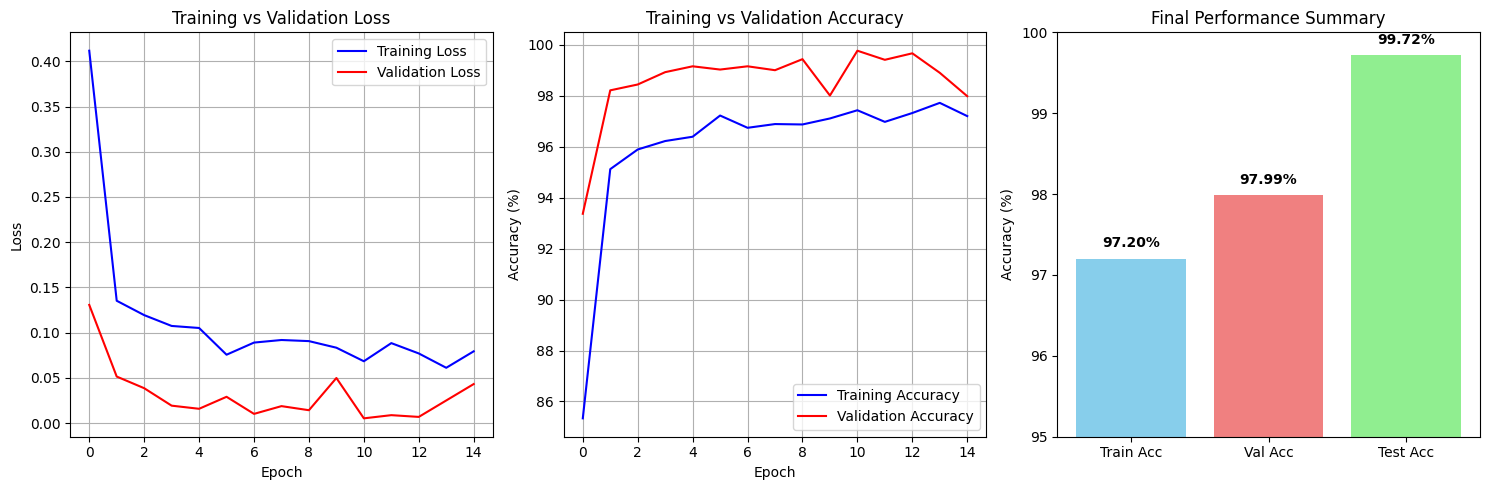

✅ Step 15 Complete: Comprehensive evaluation done!


In [22]:
# ================================
# COMPREHENSIVE EVALUATION - STEP 15
# ================================

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

print("🔍 COMPREHENSIVE MODEL EVALUATION")
print("="*50)

# Test set evaluation
def evaluate_model(model, test_loader, device):
    """Comprehensive model evaluation"""
    model.eval()
    all_predictions = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    return test_accuracy, all_predictions, all_labels

# Evaluate on test set
test_accuracy, predictions, true_labels = evaluate_model(model, advanced_test_loader, device)

print(f"🎯 FINAL TEST ACCURACY: {test_accuracy:.2f}%")

# Plot training curves
plt.figure(figsize=(15, 5))

# Plot 1: Loss curves
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy curves
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot 3: Performance summary
plt.subplot(1, 3, 3)
metrics = ['Train Acc', 'Val Acc', 'Test Acc']
values = [train_accuracies[-1], val_accuracies[-1], test_accuracy]
colors = ['skyblue', 'lightcoral', 'lightgreen']
bars = plt.bar(metrics, values, color=colors)
plt.title('Final Performance Summary')
plt.ylabel('Accuracy (%)')
plt.ylim(95, 100)

# Add value labels on bars
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{value:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Step 15 Complete: Comprehensive evaluation done!")


🔍 MINORITY vs MAJORITY CLASS PERFORMANCE
Minority Classes Average F1-Score: 0.9969
Majority Classes Average F1-Score: 0.9975
Overall Average F1-Score: 0.9974

📊 BEST PERFORMING CLASSES:
 Class  F1-Score  Is_Minority
     0       1.0         True
     6       1.0        False
     7       1.0        False
     8       1.0        False
    11       1.0        False

📊 CLASSES NEEDING ATTENTION:
 Class  F1-Score  Is_Minority  Quality_Issues
    24  0.981132         True           11.11
    21  0.985075         True            3.33
    20  0.985915        False           25.56
     5  0.986737        False           22.74
    30  0.989011        False            6.22


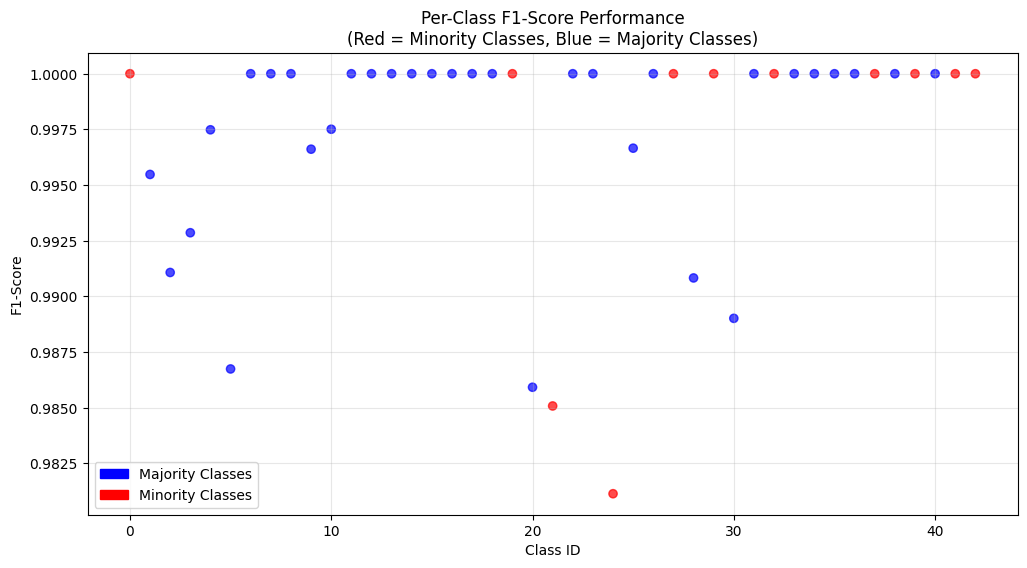

✅ Step 16 Complete: Class-wise analysis done!


In [23]:
# ================================
# CLASS-WISE PERFORMANCE ANALYSIS - STEP 16
# ================================

from sklearn.metrics import precision_recall_fscore_support

# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    true_labels, predictions, average=None, zero_division=0
)

# Create performance DataFrame
performance_df = pd.DataFrame({
    'Class': range(43),
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support,
    'Is_Minority': [i in minority_classes_real for i in range(43)],
    'Quality_Issues': [quality_analysis_real[i]['quality_percentage'] for i in range(43)],
    'Class_Weight': [class_weights_real[i] for i in range(43)]
})

# Analyze minority class performance
minority_performance = performance_df[performance_df['Is_Minority'] == True]
majority_performance = performance_df[performance_df['Is_Minority'] == False]

print("🔍 MINORITY vs MAJORITY CLASS PERFORMANCE")
print("="*50)
print(f"Minority Classes Average F1-Score: {minority_performance['F1-Score'].mean():.4f}")
print(f"Majority Classes Average F1-Score: {majority_performance['F1-Score'].mean():.4f}")
print(f"Overall Average F1-Score: {performance_df['F1-Score'].mean():.4f}")

# Show worst and best performing classes
print(f"\n📊 BEST PERFORMING CLASSES:")
best_classes = performance_df.nlargest(5, 'F1-Score')[['Class', 'F1-Score', 'Is_Minority']]
print(best_classes.to_string(index=False))

print(f"\n📊 CLASSES NEEDING ATTENTION:")
worst_classes = performance_df.nsmallest(5, 'F1-Score')[['Class', 'F1-Score', 'Is_Minority', 'Quality_Issues']]
print(worst_classes.to_string(index=False))

# Visualize class performance
plt.figure(figsize=(12, 6))
colors = ['red' if minority else 'blue' for minority in performance_df['Is_Minority']]
plt.scatter(performance_df['Class'], performance_df['F1-Score'], c=colors, alpha=0.7)
plt.xlabel('Class ID')
plt.ylabel('F1-Score')
plt.title('Per-Class F1-Score Performance\n(Red = Minority Classes, Blue = Majority Classes)')
plt.grid(True, alpha=0.3)

# Create custom legend
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Minority Classes')
blue_patch = mpatches.Patch(color='blue', label='Majority Classes')
plt.legend(handles=[blue_patch, red_patch])

plt.show()

print("✅ Step 16 Complete: Class-wise analysis done!")


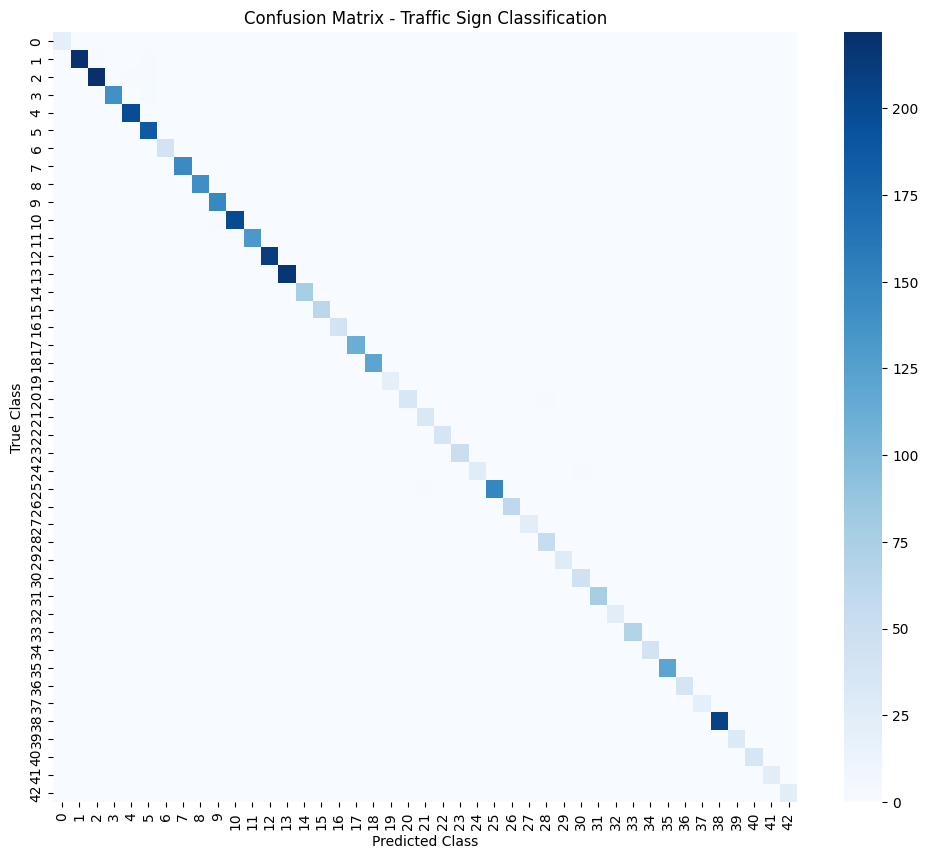

🔍 TOP 10 CLASS CONFUSIONS:
 True_Class  Predicted_Class  Count  True_Is_Minority
          2                5      2             False
          3                5      2             False
          1                2      1             False
          1                5      1             False
          2                4      1             False
         10                9      1             False
         20               28      1             False
         24               30      1              True
         25               21      1             False
✅ Step 17 Complete: Confusion matrix analysis done!


In [24]:
# ================================
# CONFUSION MATRIX ANALYSIS - STEP 17
# ================================

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='d', cbar=True)
plt.title('Confusion Matrix - Traffic Sign Classification')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Find most confused classes
confusion_pairs = []
for i in range(43):
    for j in range(43):
        if i != j and cm[i][j] > 0:
            confusion_pairs.append({
                'True_Class': i,
                'Predicted_Class': j,
                'Count': cm[i][j],
                'True_Is_Minority': i in minority_classes_real,
                'Pred_Is_Minority': j in minority_classes_real
            })

# Sort by confusion count
confusion_df = pd.DataFrame(confusion_pairs)
top_confusions = confusion_df.nlargest(10, 'Count')

print("🔍 TOP 10 CLASS CONFUSIONS:")
print("="*50)
print(top_confusions[['True_Class', 'Predicted_Class', 'Count', 'True_Is_Minority']].to_string(index=False))

print("✅ Step 17 Complete: Confusion matrix analysis done!")
